# Obliczenia hybrydowe

W przypadku obliczeń (kwantowych) `hybrydowe` oznacza strategię mieszania klasycznych i kwantowych obliczeń. 
Idea ta jest podstawowym elementem optymalizacji obwodów wariacyjnych, gdzie kwantowy obwód optymalizowany jest z wykorzystaniem klasycznego ko-procesora.

Najczęściej, obwody (i komputery) kwantowe będziemy wykorzystywać do oszacowania (obliczania) średnich z wyników pomiarów (wartość oczekiwana obserwabli),
które złozyć mozna do pojedynczej klasycznej funkcji kosztu. 
Pozwola nam to oszacować jak dobrze wybrane obwody kwantowe dopasowują się do danych. 
Przykładem moze być model realizowany jako `variational quantum eigensolver` [Peruzzo 2013](https://arxiv.org/abs/1304.3061)

![](../img/vqa.png)


W ogólności łatwo wyobrazić sobie bardziej interesujący sposób w którym mozna łączyć składniki klasyczne i kwantowe w większy i bardziej złozony układ
Kazdy element (czy to kwantowy czy klasyczny) mozna w takim obrazku przedstawić jako klasyczny bądź kwantowy `node`. 

Klasyczne i kwantowe nody mozemy składać w dowolny acykliczny graf (DAG). 
Informacja w takim grafie przebiega w ustalonym kierunku oraz nie występują w nim cykle (pętle). 
 
Jednym z przykładów takiego DAG'a są sieci neuronowe. 

Poniewaz mozemy obliczać gradienty variacyjnych obwodów kwantowych, obliczenia hybrydowe są kompatybilne z algorytmem propagacji wstecznej.
Potwierdza to możliwość trenowania obwodów kwantowych w taki sam sposób w jaki trenuje sie klasyczne sieci neuronowe. 

Korzystając z biblioteki PyTorch możemy generować sieci neuronowe korzystając z modułu `nn`. 
Każdy taki model składa się z elementarnych warstw (ang. _layers_). 
Bilioteka PennyLane pozwala przetworzyć obiekt `QNode` do obiektu `torch.nn`.

W pierwszym kroku stwórzmy dwa zestawy danych. Pierwszy dotyczyć będzie wartości ciągłej, natomiast drugi będzie realizował proces klasyfikacji. 

Dane muszą być przekształcone do obiektu tensora realizowanego w bibliotece torch.

/var/folders/53/b8z3c5xs0l51w2mzflnyk6400000gn/T/ipykernel_32725/3225078706.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(X_cont, requires_grad=True).float()
/var/folders/53/b8z3c5xs0l51w2mzflnyk6400000gn/T/ipykernel_32725/3225078706.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_cont_noise, requires_grad=True).float()


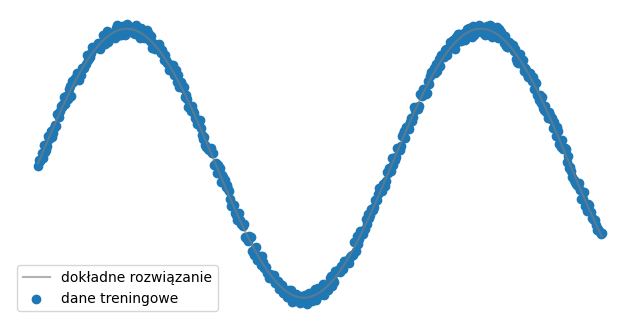

In [10]:
# DANE  dla przewidywania zmiennej ciągłej - funkcja sinus z drobnym szumem
import torch

torch.manual_seed(123)

X_cont = torch.linspace(0,10,500).view(-1,1)
y_cont = torch.sin(X_cont)
y_cont_noise = y_cont + 0.1*(torch.rand(500).view(-1,1)-0.5)

x_train = torch.tensor(X_cont, requires_grad=True).float()
y_train = torch.tensor(y_cont_noise, requires_grad=True).float()

# wyktres
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(X_cont, y_cont.view(-1,1), color="tab:grey", alpha=0.6, label="dokładne rozwiązanie")
plt.scatter(X_cont, y_cont_noise, label="dane treningowe")
plt.axis("off")
plt.legend()
plt.show()

Możemy również przygotować dane dla procesu klasyfikacji

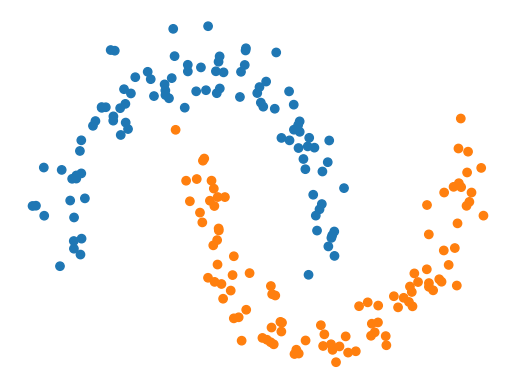

In [12]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.1)
y_ = torch.unsqueeze(torch.tensor(y), 1)  # target w kodowaniu one-hot
y_hot = torch.scatter(torch.zeros((200, 2)), 1, y_, 1)


c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # kolorowanie
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

X = torch.tensor(X, requires_grad=True).float()
y_hot = y_hot.float()

Zanim przejdziemy do daleszego etapy zdefiniujmy dodatkowe funkcje przydatne do eksploracji sieci neuronowych.

In [13]:
def mse(y, y_pred) -> torch.Tensor:
    return torch.mean((y-y_pred)**2)

def special_loss_fn(y, y_pred) -> torch.Tensor:
    return mse(y, y_pred) + torch.mean((y_pred - torch.sin(x))**2)

def train(X, Y, model, optimiser, iteration, lossfn, callback = None):
    """ Dodatkowa funkcja pozwalająca wykonać trenowanie naszej sieci neuronowej"""
    for i in range(iteration):
        optimiser.zero_grad()
        prediction = model(X)
        loss = lossfn(Y, prediction)
        loss.backward()
        optimiser.step()
        if callback != None: 
            callback(model, loss)

losses = []

def callback(model, loss):
    losses.append(loss.item())

    clear_output(wait=True)
    prediction = model(x).detach()
    plt.figure(figsize=(6,2.5))
    plt.plot(x[:,0].detach(), torch.sin(x)[:,0].detach(), label="Exact solution", color="tab:grey", alpha=0.6)
    plt.plot(x[:,0].detach(), prediction[:,0], label="QML solution", color="tab:green")
    plt.title(f"Training step {len(losses)}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,2.5))
    plt.title('Lossfn Visualised')
    plt.plot(losses)
    plt.show()

W następnym kroku zdefiniujmy obiekt realizujący obwód kwantowy: QNode, który chcemy podpiąć pod `torch.nn`. 
Dla uproszczenia sytuacji przyjmiemy obwód wykorzystujący 2 kubity.



In [14]:
import pennylane as qml

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)
# NASZ kwantowy PQC - parametryzowany obwód kwantowy dla jednej warstwy ukrytej
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

Obwód ten pobiera dane wejściowe i przetwarza je za pomocą zdefiniowanego obwodu kodującego dane `Angle Embedding`. 
Następnie wynik tej operacji,czyli dane zanurzone do przestrzeni Hilberta stanów, są przetwarzane (obracane przez parametryczne bramki z wagami) jest przez `ansatz` (model kwantowy) z wykorzystaniem gotowego obwodu realizowanego jako `BasicENtanglerLayers`.

Całość można zrozumieć jako jedna wartwa `nn.Linear`. 

Biblioteka PennyLane udostępnia obiekt `TorchLayer`, który pozwala na taką transformację. 
Zanim jednak go użyjemy musimy utworzyć słownik z wagami. 


In [15]:
n_layers = 5

weight_shapes = {"weights": (n_layers, n_qubits)}

qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

In [16]:
class QN(torch.nn.Module):
    '''Classical -> Quantum -> Classical'''

    def __init__(self, n_input: int, n_output: int, quanutm_layer):
        super().__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(n_input, n_qubits),
            quanutm_layer,
            torch.nn.Linear(n_qubits, n_output)
        )
        

    def forward(self, x):
        return  self.layers(x)
    

## definicja nie obiektowa dla problemu klasyfikacji

class QN2(torch.nn.Module):
    '''Classical -> Quantum -> Classical'''

    def __init__(self, quanutm_layer):
        super().__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, 2),
            quanutm_layer,
            torch.nn.Linear(2, 2),
            torch.nn.Softmax(dim=1)
        )
        

    def forward(self, x):
        return  self.layers(x)

Dla przypadku estymacji funkcji sinus mamy jedną zmienną (`x_cont`) wejściową która zostanie połączona z dwoma kubitami następnie na wyjściu mamy również jedną zmienną (`y_cont`).

In [17]:
reg_qmodel = QN(1, 1, qlayer)
print(reg_qmodel)

qclassifier = QN2(qlayer)
print(qclassifier)

QN(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=2, bias=True)
    (1): <Quantum Torch Layer: func=qnode>
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
)
QN2(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): <Quantum Torch Layer: func=qnode>
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): Softmax(dim=1)
  )
)


In [19]:
from IPython.display import clear_output 
learning_rate=1e-3

optimiser = torch.optim.Adam(reg_qmodel.parameters(), lr=learning_rate)

opt = torch.optim.Adam(qclassifier.parameters(), lr=learning_rate)

train(x_train, y_train, reg_qmodel, optimiser, 500, mse, callback)

NameError: name 'x' is not defined

In [ ]:
def plot_result(x,y,x_data,y_data,yh, title=None):

    plt.figure(figsize=(8,4))
    plt.title(title)
    plt.plot(x,y, color="tab:grey", alpha=0.6, label="Exact solution")
    plt.plot(x,yh, color="tab:green", label="Neural network prediction")
    plt.scatter(x_data, y_data, alpha=0.3, label='Training data')
    l = plt.legend(loc='best')

plot_result(
    x.detach(),
    torch.sin(x).detach(),
    x.detach(),
    y.detach(),
    qmodel(x).detach(),
    title='Training of PINN'
    )

In [ ]:
mse(qmodel(x), torch.sin(x))

## Klasyfikacja z wykorzystaniem kwantowej sieci neuronowej 